# Kalman filter

Let's work with linear gaussian system


$\begin{equation*}
 \begin{cases}
   X_t = a_t X_{t-1} + c_t + b_t V_t, t \in N, X_0 \sim N(m_0, D_0)\\
   Y_t = A_t X_t + C_t + B_t W_t \\
   Y_0 = A_0 X_0 + C_0 + B_0 W_0
 \end{cases}
\end{equation*}$

$Y$ - observing value, have to estimate $X$

Let's find optimal estimation $\hat{X}_t$ for $X$ and it's covariation $k_t = cov(\hat{X}_t - X_t, \hat{X}_t - X_t)$ by Kalman Filter

Start:

$\hat{X}_0 = m_0 + D_0 A_{0}^{T} {(A_0 D_0 A_{0}^{T} + B_0 B_{0}^{T})}^{+} (Y_0 - A_0 m_0 - C_0)$

$k_0 = D_0 - D_0 A_{0}^{T}  {(A_0 D_0 A_{0}^{T} + B_0 B_{0}^{T})}^{+}  A_0 D_0$


Step Prediction:

$\tilde{X_t} = E[X_t | Y_t] = a_t \hat{X}_{t-1} + c_t$

$\tilde{k_t} = cov(\tilde{X_t} - X_t, \tilde{X_t} - X_t) = a_t k_{t-1} {a}_{t}^{T}  + b_t {b}_{t}^{T}$

Step Correction:

$\hat{X}_t = \tilde{X_t} + \tilde{k_t} A_{t}^{T} {(A_t \tilde{k_t} A_{t}^{T} + B_t B_{t}^{T})}^{+} (Y_t - A_t \tilde{X_t} - C_t)$

$k_t = \tilde{k_t} - \tilde{k_t} A_{t}^{T}  {(A_t \tilde{k_t} A_{t}^{T} + B_t B_{t}^{T})}^{+}  A_t \tilde{k_t}$

\
Here is realization for one-dimensional variable $X$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from scipy import integrate
from tqdm.notebook import tqdm

In [132]:
class LinearGaussianSystem:
    def __init__(self, a, b, c, A, B, C, p_0, p_v, p_w):
        self.a = a
        self.b = b
        self.c = c
        self.A = A
        self.B = B
        self.C = C
        self.p_0 = p_0
        self.p_v = p_v
        self.p_w = p_w

        self.x_0 = self.p_0.rvs(size = 1)[0]
        self.pi_0 = self.p_0
        self.m0 = self.p_0.mean()
        self.D0 = self.p_0.std()

        self.time_list = []
        self.x_list = []
        self.y_list = []
        self.est_x_list = []

    def simulate_x(self, start = 0, end = 100, step = 1):
        prev_val = None
        curr_val = None

        for i in range(start, end + step, step):
            self.time_list.append(i)
            prev_val = curr_val
            if i == 0:
                curr_val = self.x_0
            else:
                V = self.p_v.rvs(size = 1)[0]
                curr_val = self.a * prev_val + self.c + self.b * V
            self.x_list.append(curr_val)
        return self.x_list

    def simulate_y(self):
        if len(self.x_list) == 0:
            print('WARNING: Probably You didn\'t simulate X')
            return []

        temp_var = self.A * np.array(self.x_list) + self.C + self.B * self.p_w.rvs(
             size = len(self.x_list))[0]
        self.y_list = list(temp_var)
        return self.y_list


    def estimate_x(self):
        self.est_x_list = []
        self.est_cov_list = []
        for i in tqdm(range(len(self.x_list))):
            if i == 0:
                # start
                X_hat = self.m0 + self.D0 * self.A * (self.A * self.D0 * self.A + self.B ** 2)**(-1) * (self.y_list[0] - self.A * self.m0 - self.C)
                self.est_x_list.append(X_hat)
                
                k0 = self.D0 - self.D0 * self.A *(self.A * self.D0 * self.A + self.B ** 2)**(-1) * self.A * self.D0
                self.est_cov_list.append(k0)
            else:
                #prediction
                X_wide = self.a * self.est_x_list[i - 1] + self.c
                k_wide = self.a * self.est_cov_list[i - 1] * self.a + self.b * self.b
                
                #correction
                X_hat = X_wide + k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * (self.y_list[i] - self.A * X_wide - self.C)
                k = k_wide - k_wide * self.A * (self.A * k_wide * self.A + self.B * self.B)**(-1) * self.A * k_wide
                
                self.est_x_list.append(X_hat)
                self.est_cov_list.append(k)
        
        return self.est_x_list

In [202]:
a = 1
b = 1
c = 0
A = 0.25
B = 1
C = 0
p_0 = ss.norm(loc = 1, scale = 5)
p_v = ss.norm(loc = 0, scale = 1)
p_w = ss.norm(loc = 0, scale = 1)

LGS = LinearGaussianSystem(a = a, b = b, c = c, A = A, B = B, C = C, p_0 = p_0, p_v = p_v, p_w = p_w)

x = LGS.simulate_x(end=100)
y = LGS.simulate_y()

In [203]:
%%time
x_est = LGS.estimate_x()

  0%|          | 0/101 [00:00<?, ?it/s]

CPU times: total: 31.2 ms
Wall time: 23.9 ms


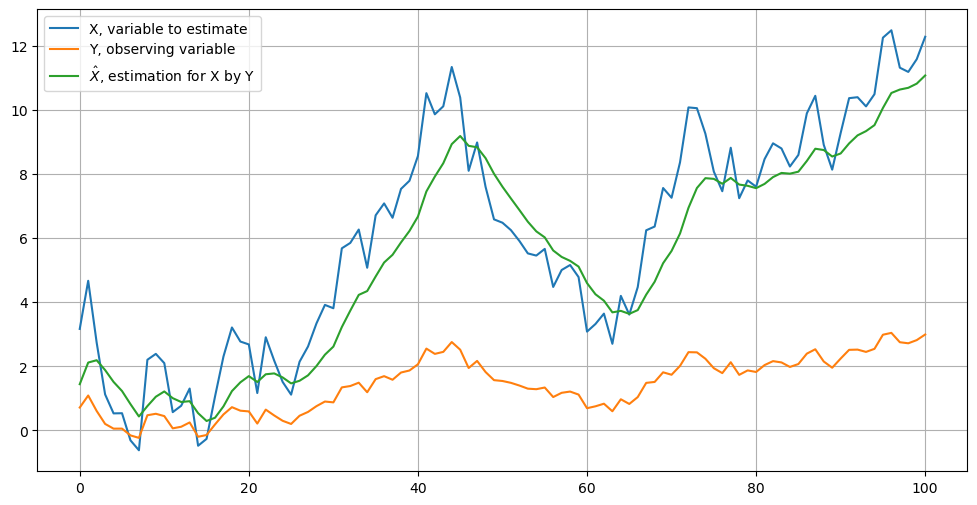

In [204]:
plt.figure(figsize=(12, 6))
plt.grid(True)

t = LGS.time_list
plt.plot(t, x, label='X, variable to estimate')
plt.plot(t, y, label='Y, observing variable')
plt.plot(t, x_est, label="$\hat{X}$, estimation for X by Y")
plt.legend()

## Results

Kalman filter is really quick and enough efficient filter to make estimation for linear systems